## Imports

In [1]:
import os
import pysam
import upsetplot

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.font_manager as fm

from google.cloud import storage
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML

/tmp/ipykernel_133/194139976.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# ! pip install upsetplot

## Constants

### User Inputs

In [3]:
use_cache = True

# subset = "clustered_raw_calls"
subset = "filtered"

vcf1 = "conc_dragen_by_manta"
vcf2 = "conc_manta_by_dragen"

vcf1_name = "DRAGEN"
vcf2_name = "Manta"

min_size_cache = None
max_size_cache = None
valid_types_cache = None

min_size_filter = None
max_size_filter = None
valid_types_filter = None

sr_callers = ["depth", "dragen", "manta", "scramble", "wham"]
    
info_fields = ["AF", "STRAT", "TRUTH_VID"]

fmt_fields = ["GT", "GQ", "SL"]

### Additional

In [4]:
in_dir = f"/home/jupyter/Files/overlap_calls/inputs/{subset}"
out_dir = f"/home/jupyter/Files/overlap_calls/outputs/{subset}"
os.makedirs(out_dir, exist_ok=True)

vcf1_file_path = os.path.join(in_dir, f"{vcf1}.txt")
vcf1_output_path = os.path.join(out_dir, f"{vcf1}.tsv")

vcf2_file_path = os.path.join(in_dir, f"{vcf2}.txt")
vcf2_output_path = os.path.join(out_dir, f"{vcf2}.tsv")

cached_df_path = os.path.join(out_dir, f"{subset}.cached.tsv")

fm.fontManager.addfont(os.path.join("/home/jupyter/Files/overlap_calls/inputs", "arial.ttf"))
fm.fontManager.addfont(os.path.join("/home/jupyter/Files/overlap_calls/inputs", "arialbd.ttf"))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

chrom_order = {f'chr{i}': i for i in range(1, 23)}
chrom_order.update({'chrX': 23, 'chrY': 24})

SV_ORDER = ['BND', 'CNV', 'CPX', 'CTX', 'DEL', 'DUP', 'INS', 'INV']
cmap = cm.get_cmap('Set2', len(SV_ORDER))
COLOR_MAP = {sv: cmap(i) for i, sv in enumerate(SV_ORDER)}

/tmp/ipykernel_133/3358332714.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(SV_ORDER))


## Helper Functions

In [5]:
_gt_non_ref_map = dict()

def _is_non_ref(gt):
    s = _gt_non_ref_map.get(gt, None)
    if s is None:
        s = any([a is not None and a > 0 for a in gt])
        _gt_non_ref_map[gt] = s
    return s

In [6]:
def assign_status(val):
    if 'TP' in val:
        return 1
    elif any(x in val for x in ['FP', 'FN', 'EMPTY']):
        return 0
    else:
        raise Exception(f"{val} is an unexpected CONC_ST type - please resolve.")

In [7]:
def plot_upset(df, source_display=('vcf1', 'vcf2'), save_path=None, 
               ylabel_fontsize=None, set_label_fontsize=None, tick_label_fontsize=None, 
               ylim=None, figsize=None):
    disp1, disp2 = source_display
    n_samples = df['SAMPLE'].nunique()
    sup1 = df[(df.SOURCE == 'vcf1') & (df.STATUS_SITE == 1)]['SVTYPE'].value_counts()
    sup2 = df[(df.SOURCE == 'vcf2') & (df.STATUS_SITE == 1)]['SVTYPE'].value_counts()

    overlap = ((sup1.add(sup2, fill_value=0) / 2).round().astype(int))
    excl1 = df[(df.SOURCE == 'vcf1') & (df.STATUS_SITE == 0)]['SVTYPE'].value_counts()
    excl2 = df[(df.SOURCE == 'vcf2') & (df.STATUS_SITE == 0)]['SVTYPE'].value_counts()

    rows = []
    for sv, cnt in overlap.items():
        rows += [{disp1: True, disp2: True, 'SVTYPE': sv, 'weights': 1 / n_samples}] * cnt
    for sv, cnt in excl1.items():
        rows += [{disp1: True, disp2: False, 'SVTYPE': sv, 'weights': 1 / n_samples}] * cnt
    for sv, cnt in excl2.items():
        rows += [{disp1: False, disp2: True, 'SVTYPE': sv, 'weights': 1 / n_samples}] * cnt

    upset_df = pd.DataFrame(rows).set_index([disp1, disp2])
    upset = upsetplot.UpSet(
        upset_df,
        subset_size='sum',
        sum_over='weights',
        intersection_plot_elements=0,
        sort_by='cardinality'
    )

    upset.add_stacked_bars(by='SVTYPE', sum_over='weights', colors=COLOR_MAP, title='Calls per Genome', elements=10)
    if figsize is not None:
        fig = plt.figure(figsize=figsize, dpi=300)
    else:
        fig = plt.figure(dpi=300)
    axes = upset.plot(fig=fig)
    
    if ylabel_fontsize is not None:
        axes['extra0'].yaxis.label.set_fontsize(ylabel_fontsize)
        axes['extra0'].yaxis.label.set_fontweight('bold')
    if set_label_fontsize is not None:
        axes['matrix'].tick_params(axis='y', labelsize=set_label_fontsize)
    if tick_label_fontsize is not None:
        axes['extra0'].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
    if ylim is not None:
        axes['extra0'].set_ylim(ylim)

    axes['extra0'].legend(
        loc='upper left',
        bbox_to_anchor=(1, 1),
        borderaxespad=0,
        frameon=False,
        facecolor='none'
    )
    
    if save_path:
        fig.savefig(save_path, transparent=True, dpi=300, bbox_inches='tight')

    plt.show()

In [8]:
def plot_upset_old(df, source_display=('vcf1','vcf2'), ylim=None):
    disp1, disp2 = source_display
    n_samples = df['SAMPLE'].nunique()
    sup1 = df[(df.SOURCE=='vcf1') & (df.STATUS_SITE==1)]['SVTYPE'].value_counts()
    sup2 = df[(df.SOURCE=='vcf2') & (df.STATUS_SITE==1)]['SVTYPE'].value_counts()

    overlap = ((sup1.add(sup2, fill_value=0) / 2).round().astype(int))
    excl1 = df[(df.SOURCE=='vcf1') & (df.STATUS_SITE==0)]['SVTYPE'].value_counts()
    excl2 = df[(df.SOURCE=='vcf2') & (df.STATUS_SITE==0)]['SVTYPE'].value_counts()

    rows = []
    for sv, cnt in overlap.items():
            rows += [{disp1: True, disp2: True, 'SVTYPE': sv, 'weights': 1/n_samples}] * cnt
    for sv, cnt in excl1.items():
            rows += [{disp1: True, disp2: False, 'SVTYPE': sv, 'weights': 1/n_samples}] * cnt
    for sv, cnt in excl2.items():
            rows += [{disp1: False, disp2: True, 'SVTYPE': sv, 'weights': 1/n_samples}] * cnt

    upset_df = pd.DataFrame(rows).set_index([disp1, disp2])
    upset = upsetplot.UpSet(
            upset_df,
            subset_size='sum',
            sum_over='weights',
            intersection_plot_elements=0,
            sort_by='cardinality'
    )

    upset.add_stacked_bars(by='SVTYPE', sum_over='weights', colors=COLOR_MAP, title='Calls per Genome', elements=10)
    fig = plt.figure(dpi=100)
    axes = upset.plot(fig=fig)

    if ylim is not None:
            axes['extra0'].set_ylim(ylim)

    axes['extra0'].legend(
            loc='upper left',
            bbox_to_anchor=(1.02, 1),
            borderaxespad=0
    )

    plt.show()

## Process

### Verification

In [9]:
if not use_cache and os.path.exists(cached_df_path):
    raise Exception("Cached file already exists at given location - are you sure you wish to proceed?")

In [10]:
if use_cache and not os.path.exists(cached_df_path):
    raise Exception("Cached file does not exist at given location - please set use_cache to False.")

### File Generation

In [11]:
# Load VCF 1

if not use_cache:
    gcs_client = storage.Client()
    
    with open(vcf1_output_path, "w") as tsv:
        pass
    
    with open(vcf1_file_path, 'r') as f:
        vcf1_paths = [line.strip() for line in f if line.strip()]
        
    for vcf1_path in vcf1_paths:
        bucket_name, object_name = vcf1_path[5:].split("/", 1)
        local_vcf = os.path.join("/tmp/vcf1_cache", os.path.basename(object_name))
        os.makedirs(os.path.dirname(local_vcf), exist_ok=True)
        gcs_client.bucket(bucket_name).blob(object_name).download_to_filename(local_vcf)
        
        with pysam.VariantFile(local_vcf) as vcf, open(vcf1_output_path, "a") as tsv:
            tsv.write(
                "\t".join(
                    ["VID", "SAMPLE", "CHROM", "POS", "SVTYPE", "SVLEN", "FILTER", "STATUS_SITE", "STATUS_SAMPLE"]
                    + [sc.upper() for sc in sr_callers]
                    + info_fields
                    + fmt_fields
                )
                + "\n"
            )

            for r in vcf:
                svtype = r.info.get("SVTYPE", None)
                svlen = r.info.get("SVLEN", None) if r.info.get("SVLEN", None) else (r.stop - r.pos)
                svlen = -1 if svlen == 0 else svlen
                filters = ",".join(f for f in r.filter)

                if valid_types_cache is not None:
                            if svtype not in valid_types_cache:
                                continue

                if max_size_cache is not None:
                    if svlen > max_size_cache:
                        continue

                if min_size_cache is not None:
                    if svlen < min_size_cache:
                        continue
                     
                row_data = []
                for s in r.samples:
                    if _is_non_ref(r.samples[s]["GT"]):
                        base = [
                            r.id,
                            s,
                            r.chrom,
                            r.pos,
                            svtype,
                            svlen,
                            filters,
                            1 if r.info.get("STATUS", "") == "TP" else 0,
                            r.samples[s].get("CONC_ST")
                        ]

                        algos = r.info.get("ALGORITHMS", [])
                        if isinstance(algos, str):
                            algos = [algos]

                        sr_flags = []
                        for sc in sr_callers:
                            if sc in algos:
                                sr_flags.append(1)
                            else:
                                sr_flags.append(0)
                                
                        infs = [r.info.get(k, None) for k in info_fields if k in info_fields]
                                
                        fmts = [r.samples[s].get(k, None) for k in fmt_fields if k in fmt_fields]
                        
                        row_data.append(base + sr_flags + infs + fmts)

                if row_data:
                    for rd_ in row_data:
                        tsv.write("\t".join(str(x) for x in rd_) + "\n")

In [12]:
# Load VCF 2

if not use_cache:
    gcs_client = storage.Client()
    
    with open(vcf2_output_path, "w") as tsv:
        pass
    
    with open(vcf2_file_path, 'r') as f:
        vcf2_paths = [line.strip() for line in f if line.strip()]
        
    for vcf2_path in vcf2_paths:
        bucket_name, object_name = vcf2_path[5:].split("/", 1)
        local_vcf = os.path.join("/tmp/vcf2_cache", os.path.basename(object_name))
        os.makedirs(os.path.dirname(local_vcf), exist_ok=True)
        gcs_client.bucket(bucket_name).blob(object_name).download_to_filename(local_vcf)
        
        with pysam.VariantFile(local_vcf) as vcf, open(vcf2_output_path, "a") as tsv:
            tsv.write(
                "\t".join(
                    ["VID", "SAMPLE", "CHROM", "POS", "SVTYPE", "SVLEN", "FILTER", "STATUS_SITE", "STATUS_SAMPLE"]
                    + [sc.upper() for sc in sr_callers]
                    + info_fields
                    + fmt_fields
                )
                + "\n"
            )

            for r in vcf:
                svtype = r.info.get("SVTYPE", None)
                svlen = r.info.get("SVLEN", None) if r.info.get("SVLEN", None) else (r.stop - r.pos)
                svlen = -1 if svlen == 0 else svlen
                filters = ",".join(f for f in r.filter)

                if valid_types_cache is not None:
                            if svtype not in valid_types_cache:
                                continue

                if max_size_cache is not None:
                    if svlen > max_size_cache:
                        continue

                if min_size_cache is not None:
                    if svlen < min_size_cache:
                        continue
                     
                row_data = []
                for s in r.samples:
                    if _is_non_ref(r.samples[s]["GT"]):
                        base = [
                            r.id,
                            s,
                            r.chrom,
                            r.pos,
                            svtype,
                            svlen,
                            filters,
                            1 if r.info.get("STATUS", "") == "TP" else 0,
                            r.samples[s].get("CONC_ST")
                        ]

                        algos = r.info.get("ALGORITHMS", [])
                        if isinstance(algos, str):
                            algos = [algos]

                        sr_flags = []
                        for sc in sr_callers:
                            if sc in algos:
                                sr_flags.append(1)
                            else:
                                sr_flags.append(0)
                                
                        infs = [r.info.get(k, None) for k in info_fields if k in info_fields]
                                
                        fmts = [r.samples[s].get(k, None) for k in fmt_fields if k in fmt_fields]
                        
                        row_data.append(base + sr_flags + infs + fmts)

                if row_data:
                    for rd_ in row_data:
                        tsv.write("\t".join(str(x) for x in rd_) + "\n")

### Dataframe Processing

In [13]:
# Format VCF 1

if not use_cache:
    df1 = pd.read_csv(vcf1_output_path, sep="\t")

    # Set column types
    df1 = df1[df1['SVLEN'] != 'SVLEN']
    df1 = df1.dropna(subset=["SVLEN"]).astype({"SVLEN": int, "SVTYPE": str})
    if "GQ" in df1.columns:
        df1["GQ"] = df1["GQ"].astype(float)
    if "SL" in df1.columns:
        df1["SL"] = df1["SL"].astype(float)
        
    # Process AF
    clean = df1["AF"].str.replace(r"[(),]", "", regex=True)
    df1["AF"] = pd.to_numeric(clean, errors="coerce")

    # Process STRAT
    def assign_strat(s):
        if pd.isna(s):
            return "Unique"
        elif "SR_" in s:
            return "SR"
        elif "SD_" in s:
            return "SD"
        elif "RM_" in s:
            return "RM"
        else:
            return "Unique"
    df1["STRAT"] = df1["STRAT"].apply(assign_strat)
        
    # Process STATUS_SAMPLE
    df1['STATUS_SAMPLE'] = df1['STATUS_SAMPLE'].apply(assign_status)

    # Process categorical
    df1['SVTYPE'] = pd.Categorical(df1['SVTYPE'])
    df1['STRAT'] = pd.Categorical(df1['STRAT'])
    
    # Set log_SVLEN
    df1["log_SVLEN"] = np.log10(df1["SVLEN"].where(df1["SVLEN"] > 0, np.nan))

    # Set SIZE
    df1["SIZE"] = df1["SVLEN"]
    df1.loc[df1["SVTYPE"] == "DEL", "SIZE"] = -df1.loc[df1["SVTYPE"] == "DEL", "SIZE"]

    # Set SRWGS
    def sr_any(row):
        return any(row[sc.upper()] == 1 for sc in sr_callers)
    df1["SRWGS"] = df1.apply(sr_any, axis=1).astype(int)

    # Set SUPPORT
    df1["SUPPORT"] = "Unsupported"
    df1.loc[(df1["SRWGS"] == 1) & (df1["STATUS_SITE"] == 1), "SUPPORT"] = "Supported"
    df1['SUPPORT'] = pd.Categorical(df1['SUPPORT'])
    
    # Set SOURCE
    df1["SOURCE"] = "vcf1"

In [14]:
# Format VCF 2

if not use_cache:
    df2 = pd.read_csv(vcf2_output_path, sep="\t")

    # Set column types
    df2 = df2[df2['SVLEN'] != 'SVLEN']
    df2 = df2.dropna(subset=["SVLEN"]).astype({"SVLEN": int, "SVTYPE": str})
    if "GQ" in df2.columns:
        df2["GQ"] = df2["GQ"].astype(float)
    if "SL" in df2.columns:
        df2["SL"] = df2["SL"].astype(float)
        
    # Process AF
    clean = df2["AF"].str.replace(r"[(),]", "", regex=True)
    df2["AF"] = pd.to_numeric(clean, errors="coerce")

    # Process STRAT
    df2["STRAT"] = df2["STRAT"].apply(assign_strat)
    
    # Process STATUS_SAMPLE
    df2['STATUS_SAMPLE'] = df2['STATUS_SAMPLE'].apply(assign_status)

    # Process categorical
    df2['SVTYPE'] = pd.Categorical(df2['SVTYPE'])
    df2['STRAT'] = pd.Categorical(df2['STRAT'])
    
    # Set log_SVLEN
    df2["log_SVLEN"] = np.log10(df2["SVLEN"].where(df2["SVLEN"] > 0, np.nan))

    # Set SIZE
    df2["SIZE"] = df2["SVLEN"]
    df2.loc[df2["SVTYPE"] == "DEL", "SIZE"] = -df2.loc[df2["SVTYPE"] == "DEL", "SIZE"]

    # Set SRWGS
    def sr_any(row):
        return any(row[sc.upper()] == 1 for sc in sr_callers)
    df2["SRWGS"] = df2.apply(sr_any, axis=1).astype(int)

    # Set SUPPORT
    df2["SUPPORT"] = "Unsupported"
    df2.loc[(df2["SRWGS"] == 1) & (df2["STATUS_SITE"] == 1), "SUPPORT"] = "Supported"
    df2["SUPPORT"] = pd.Categorical(df2['SUPPORT'])
    
    # Set SOURCE
    df2["SOURCE"] = "vcf2"

In [15]:
if not use_cache:
    df = pd.concat([df1, df2], ignore_index=True)
    df["SOURCE"] = pd.Categorical(df["SOURCE"])
    
    df.to_csv(cached_df_path, sep="\t", index=False)

## Load

In [16]:
df = pd.read_csv(cached_df_path, sep="\t")

df.head()

,VID,SAMPLE,CHROM,POS,SVTYPE,SVLEN,FILTER,STATUS_SITE,STATUS_SAMPLE,DEPTH,...,STRAT,TRUTH_VID,GT,GQ,SL,log_SVLEN,SIZE,SRWGS,SUPPORT,SOURCE
0,all_sample_sets.chr1.final_cleanup_DUP_chr1_2,RGP_1012_1,chr1,597701,DUP,62289,NaN,1,1,1,...,SD,all_sample_sets.chr1.final_cleanup_DUP_chr1_2,"(0, 1)",59.0,70.0,4.794411,62289,0,Unsupported,vcf1
1,all_sample_sets.chr1.final_cleanup_BND_chr1_5,RGP_1012_1,chr1,1008059,BND,-1,UNRESOLVED,0,0,0,...,Unique,NaN,"(1, 1)",12.0,-64.0,NaN,-1,0,Unsupported,vcf1
2,all_sample_sets.chr1.final_cleanup_INS_chr1_8,RGP_1012_1,chr1,1068824,INS,78,NaN,1,1,0,...,SR,all_sample_sets.chr1.final_cleanup_INS_chr1_9,"(0, 1)",85.0,147.0,1.892095,78,0,Unsupported,vcf1
3,all_sample_sets.chr1.final_cleanup_INS_chr1_12,RGP_1012_1,chr1,1187015,INS,131,NaN,1,1,0,...,RM,all_sample_sets.chr1.final_cleanup_INS_chr1_11,"(0, 1)",51.0,49.0,2.117271,131,0,Unsupported,vcf1
4,all_sample_sets.chr1.final_cleanup_DEL_chr1_27,RGP_1012_1,chr1,1207339,DEL,422,NaN,1,1,0,...,Unique,all_sample_sets.chr1.final_cleanup_DEL_chr1_22,"(0, 1)",88.0,155.0,2.625312,-422,0,Unsupported,vcf1


In [17]:
# Formatting

df['SVTYPE'] = pd.Categorical(df['SVTYPE'])
df['STRAT'] = pd.Categorical(df['STRAT'])
df['SUPPORT'] = pd.Categorical(df['SUPPORT'])
df['SOURCE'] = pd.Categorical(df['SOURCE'])

conditions = [
    df["AF"] < 0.01,
    df["AF"] < 0.05,
    df["AF"] < 0.2,
    df["AF"] < 0.5
]
choices = [
    "AF < 1%",
    "1% ≤ AF < 5%",
    "5% ≤ AF < 20%",
    "20% ≤ AF < 50%"
]
df["AF_BUCKET"] = np.select(conditions, choices, default="AF > 50%")
df["AF_BUCKET"] = pd.Categorical(
    df["AF_BUCKET"],
    categories=["AF < 1%", "1% ≤ AF < 5%", "5% ≤ AF < 20%", "20% ≤ AF < 50%", "AF > 50%"],
    ordered=True
)

In [18]:
# Filtering
  
# Remove SVLEN > max_size
if max_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] <= max_size_filter]
    print(f"[SVLEN > Max Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove SVLEN < min_size
if min_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] >= min_size_filter]
    print(f"[SVLEN < Min Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove invalid SVTYPE
# if valid_types_filter is not None:
#     bef = len(df)
#     df = df[df["SVTYPE"].isin(valid_types_filter)]
#     print(f"[Invalid SVTYPE] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove non-PASS FILTER
bef = len(df)
df = df[df["FILTER"].isna() | (df["FILTER"] == "PASS")]
print(f"[PASS Only] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

df.head()

[PASS Only] Dropped 787937 records (16.2%), now left with 4076554.



,VID,SAMPLE,CHROM,POS,SVTYPE,SVLEN,FILTER,STATUS_SITE,STATUS_SAMPLE,DEPTH,...,TRUTH_VID,GT,GQ,SL,log_SVLEN,SIZE,SRWGS,SUPPORT,SOURCE,AF_BUCKET
0,all_sample_sets.chr1.final_cleanup_DUP_chr1_2,RGP_1012_1,chr1,597701,DUP,62289,NaN,1,1,1,...,all_sample_sets.chr1.final_cleanup_DUP_chr1_2,"(0, 1)",59.0,70.0,4.794411,62289,0,Unsupported,vcf1,5% ≤ AF < 20%
2,all_sample_sets.chr1.final_cleanup_INS_chr1_8,RGP_1012_1,chr1,1068824,INS,78,NaN,1,1,0,...,all_sample_sets.chr1.final_cleanup_INS_chr1_9,"(0, 1)",85.0,147.0,1.892095,78,0,Unsupported,vcf1,AF > 50%
3,all_sample_sets.chr1.final_cleanup_INS_chr1_12,RGP_1012_1,chr1,1187015,INS,131,NaN,1,1,0,...,all_sample_sets.chr1.final_cleanup_INS_chr1_11,"(0, 1)",51.0,49.0,2.117271,131,0,Unsupported,vcf1,5% ≤ AF < 20%
4,all_sample_sets.chr1.final_cleanup_DEL_chr1_27,RGP_1012_1,chr1,1207339,DEL,422,NaN,1,1,0,...,all_sample_sets.chr1.final_cleanup_DEL_chr1_22,"(0, 1)",88.0,155.0,2.625312,-422,0,Unsupported,vcf1,5% ≤ AF < 20%
5,all_sample_sets.chr1.final_cleanup_DEL_chr1_41,RGP_1012_1,chr1,1530547,DEL,304,NaN,1,1,0,...,all_sample_sets.chr1.final_cleanup_DEL_chr1_35,"(0, 1)",86.0,150.0,2.482874,-304,0,Unsupported,vcf1,1% ≤ AF < 5%


## Analyze

In [19]:
# Print statistics of support by VCF

gb = df.groupby('SOURCE')['STATUS_SITE']

total = gb.count()
supported = gb.sum()
pct_supported = (supported / total * 100).round(2)

summary = pd.DataFrame({
    'total_variants': total,
    'supported_variants': supported,
    'percent_supported': pct_supported
})

print(summary)

        total_variants  supported_variants  percent_supported
SOURCE                                                       
vcf1           2096770             1915352              91.35
vcf2           1979784             1901916              96.07


In [20]:
# Print statistics of symmetric support by VCF 

supported = df[df['STATUS_SITE'] == 1]
sup1 = supported[supported['SOURCE'] == 'vcf1'][['VID', 'TRUTH_VID']]
sup2 = supported[supported['SOURCE'] == 'vcf2'][['VID', 'TRUTH_VID']]

pairs1 = set(map(tuple, sup1.values))
pairs2 = set(map(tuple, sup2.values))

sym1 = sum(1 for (x,y) in pairs1 if (y, x) in pairs2)
sym2 = sum(1 for (x,y) in pairs2 if (y, x) in pairs1)

tot1 = len(pairs1)
tot2 = len(pairs2)
pct1 = (sym1 / tot1 * 100) if tot1 else 0
pct2 = (sym2 / tot2 * 100) if tot2 else 0

sym_summary = pd.DataFrame({
    'total_supported': [tot1, tot2],
    'symmetric_supported': [sym1, sym2],
    'percent_symmetric': [round(pct1,2), round(pct2,2)]
}, index=['vcf1','vcf2'])

print(sym_summary)

      total_supported  symmetric_supported  percent_symmetric
vcf1            39317                38713              98.46
vcf2            39033                38713              99.18


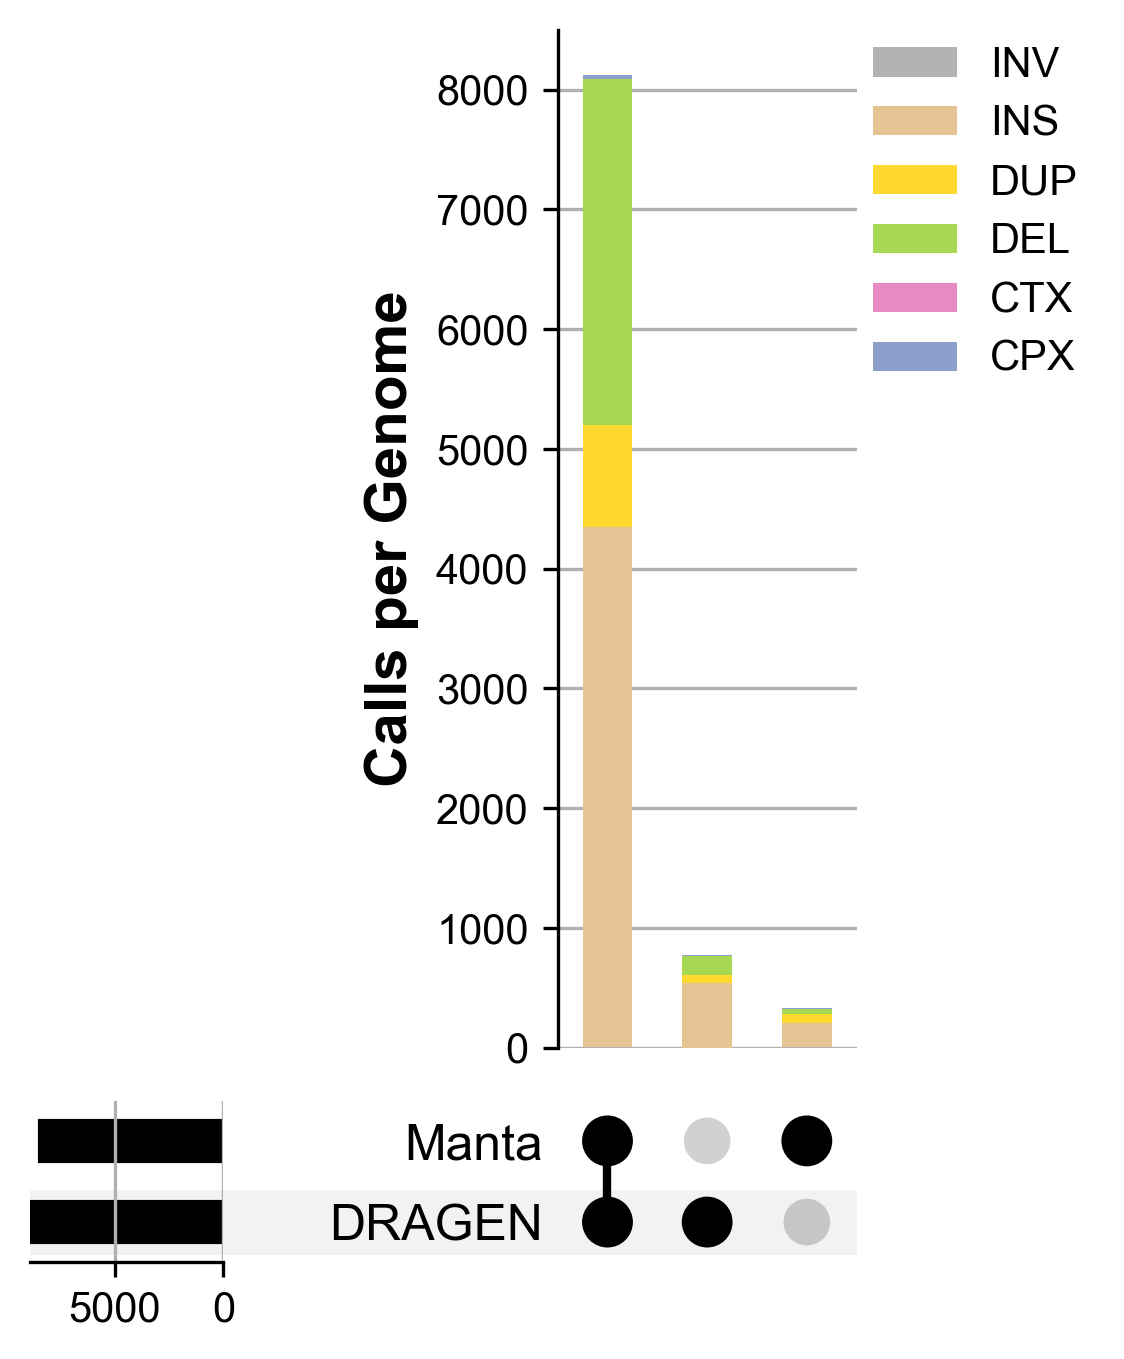

In [21]:
plot_upset(
    df, 
    source_display=(vcf1_name, vcf2_name),
    save_path=os.path.join(out_dir, "upset_plot.png"),
    ylim=(0, 8500),
    ylabel_fontsize=14,
    set_label_fontsize=12,
    tick_label_fontsize=10,
    figsize=(12, 12)
)

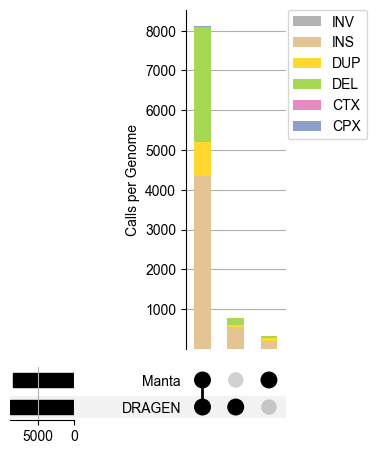

In [22]:
plot_upset_old(df, source_display=(vcf1_name, vcf2_name))